# DSC 680 Project 2 - Milestone 2 - Vision-Based Trading Signal Classification from Candlestick Chart Images
### Zicheng (Chance) Xu
### Professor: Amirfarrokh Iranitalab
### Bellevue University

## Project Introduction (Milestone 1 recap)
Financial prices move based on what traders collectively see and believe—trend, momentum, volatility, and news—often faster than we can describe in words. Candlestick charts are a compact visual summary of that behavior because they show direction, range, and volatility over time. In this project, I will test whether a machine learning model can learn useful patterns directly from candlestick chart images to predict short-term price movement. This supports a practical goal: building a repeatable workflow where a chart snapshot can be turned into a structured prediction (for example, “likely up,” “likely down,” or “uncertain”).

In this notebook, I will build an end-to-end modeling pipeline. First, I will download and clean historical daily OHLCV price data for a set of liquid tickers. Next, I will label each date using a triple-barrier method—which assigns outcomes based on whether price hits an upper barrier (up move), a lower barrier (down move), or neither within a fixed future window. Then, I will convert rolling windows of historical price data into standardized candlestick chart images that represent what a trader would have “seen” at that time.

After the data is prepared, I will train and evaluate two models step by step.
- Vision-only baseline: a convolutional neural network that predicts the triple-barrier outcome using only the chart image.
- Multi-modal model: a combined model that uses both the chart image and a small set of numeric indicators (for example, RSI and volume-based features).

To keep results realistic, I will use a time-based train/validation/test split so the model is evaluated on later time periods it has never seen. Model performance will be summarized with standard classification metrics (such as accuracy, precision/recall, and a confusion matrix), and I will compare whether adding numeric indicators improves results over the image-only baseline.

## 1. Notebook Setup and Reproducibility

### 1.1 Imports and environment check

In [5]:
# Core
import os
import sys
import math
import random
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# ML / metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Deep learning (vision)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# For a  nicer confusion matrix display later. Used try except blocks to ensure safety
try:
    import seaborn as sns
    _HAS_SEABORN = True
except Exception:
    _HAS_SEABORN = False

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("PyTorch:", torch.__version__)

# Helper: print paths relative to the notebook's working directory (BASE_DIR)
def relpath(p: Path) -> str:
    return os.path.relpath(p, start=BASE_DIR)

Python: 3.12.7
NumPy: 1.26.4
Pandas: 2.2.2
PyTorch: 2.10.0


### 1.2 Global configuration
In this section, I will define the key settings for the project (tickers, time range, labeling rules, and image settings). Keeping everything in one place makes it easier to rerun experiments and explain the workflow.

In [164]:
@dataclass
class Config:
    # Data scope
    tickers: tuple = ("SPY", "AAPL", "MSFT", "NVDA")  # start small; I may expand later
    start_date: str = "2015-01-01"
    end_date: str = "2025-12-31"  # safe default; adjustable as needed

    # Triple-barrier labeling
    horizon_days: int = 20              # look-ahead window
    pt_return: float = 0.05             # profit-take barrier (e.g., +5%)
    sl_return: float = 0.05             # stop-loss barrier (e.g., -5%)

    # Candlestick image creation
    lookback_days: int = 60             # window length used to create each image
    img_size: int = 224                 # common CNN input size
    dpi: int = 100                      # rendering DPI (affects image sharpness)
    include_volume_panel: bool = True   # include volume bars or not

    # Modeling
    batch_size: int = 32
    num_workers: int = 0                # Can set >0 if the machine supports it well; I will start at 0
    lr: float = 1e-4
    epochs: int = 15                     
    weight_decay: float = 1e-4

    # Splits (time-based)
    train_frac: float = 0.70
    val_frac: float = 0.15
    test_frac: float = 0.15

cfg = Config()
cfg

Config(tickers=('SPY', 'AAPL', 'MSFT', 'NVDA'), start_date='2015-01-01', end_date='2025-12-31', horizon_days=20, pt_return=0.05, sl_return=0.05, lookback_days=60, img_size=224, dpi=100, include_volume_panel=True, batch_size=32, num_workers=0, lr=0.0001, epochs=15, weight_decay=0.0001, train_frac=0.7, val_frac=0.15, test_frac=0.15)

### 1.3 Reproducibility and device setup
In this section, I will set random seeds so results are more repeatable across runs. I will also select CPU vs GPU automatically.

I use this block to make my results repeatable and to make sure the notebook runs on whatever hardware is available.
- First, I set the same random seed for Python, NumPy, and PyTorch so that things like data shuffling, weight initialization, and random sampling behave the same way each time I rerun the notebook. That makes it easier to debug issues and compare model changes fairly.
- Then I turn on PyTorch’s deterministic settings (cudnn.deterministic = True and cudnn.benchmark = False) so GPU operations are less “random” across runs. This can slow training a bit, but it improves consistency.

Next, I pick the computing device automatically: if a GPU is available I use it; otherwise I use the CPU.

In [9]:
def set_seed(seed: int = 42):
    """
    Make results more repeatable across runs by fixing sources of randomness.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # If CUDA is present (NVIDIA GPUs), also seed CUDA RNG
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Deterministic settings:
    # - On CUDA, these reduce nondeterminism (may be slower).
    # - On CPU/MPS, these flags are generally harmless.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

# Prefer Apple GPU (MPS) on Mac, otherwise CUDA, otherwise CPU
if getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Device:", device)
print("MPS built:", getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_built())
print("MPS available:", getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available())
print("CUDA available:", torch.cuda.is_available())

Device: mps
MPS built: True
MPS available: True
CUDA available: False


Since the output shows Device: cpu, it means PyTorch did not detect an available CUDA-enabled GPU on this machine, so the model will train on the CPU (typically slower, but it will still work).

### 1.4 Folder structure (artifacts, images, outputs)
In this section, I will create a clean folder layout so the notebook saves generated images and model outputs in a predictable location.

In [12]:
BASE_DIR = Path.cwd()
ARTIFACTS_DIR = BASE_DIR / "artifacts_project2"
DATA_DIR = ARTIFACTS_DIR / "data"
IMG_DIR = ARTIFACTS_DIR / "images"
MODEL_DIR = ARTIFACTS_DIR / "models"
RESULTS_DIR = ARTIFACTS_DIR / "results"

for d in [ARTIFACTS_DIR, DATA_DIR, IMG_DIR, MODEL_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Artifacts root:", relpath(ARTIFACTS_DIR))
print("Data folder:", relpath(DATA_DIR))
print("Images folder:", relpath(IMG_DIR))
print("Models folder:", relpath(MODEL_DIR))
print("Results folder:", relpath(RESULTS_DIR))

Artifacts root: artifacts_project2
Data folder: artifacts_project2/data
Images folder: artifacts_project2/images
Models folder: artifacts_project2/models
Results folder: artifacts_project2/results


## 2. Data Collection and Cleaning

### 2.1 Download daily OHLCV data (Stooq as primary source)
In this section, I will download historical daily price data (Open, High, Low, Close, Volume) for the tickers in my configuration. I will use Stooq first because it is free and does not require an API key. To make the notebook easier to rerun, I will also cache each ticker’s data to disk so I don’t have to re-download it every time.

In [15]:
def _standardize_ohlcv(df: pd.DataFrame, ticker: str) -> pd.DataFrame:
    """
    Standardize OHLCV columns, date index, sorting, and filtering.
    Output columns: date, open, high, low, close, volume, ticker
    """
    df = df.copy()

    # Normalize column names
    col_map = {c: c.strip().lower().replace(" ", "_") for c in df.columns}
    df.rename(columns=col_map, inplace=True)

    # Keep only what we need (some sources include adj_close)
    needed = ["open", "high", "low", "close", "volume"]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"{ticker}: missing columns {missing}. Found: {list(df.columns)}")

    # If date is a column, move it to index
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df.dropna(subset=["date"]).set_index("date")

    # Ensure datetime index
    df.index = pd.to_datetime(df.index)

    # Sort ascending by date
    df = df.sort_index()

    # Convert to numeric
    for c in needed:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Drop rows without close (or with all NaNs)
    df = df.dropna(subset=["close"])

    # Filter to configured date range 
    start = pd.to_datetime(cfg.start_date)
    end = pd.to_datetime(cfg.end_date)
    df = df.loc[(df.index >= start) & (df.index <= end)]

    # Add ticker column + return tidy format
    df["ticker"] = ticker
    df = df.reset_index().rename(columns={"index": "date"})
    df = df[["date", "open", "high", "low", "close", "volume", "ticker"]]

    return df


def fetch_ohlcv_stooq(ticker: str) -> pd.DataFrame:
    """
    Fetch OHLCV from Stooq daily CSV endpoint.
    For US tickers, Stooq typically uses the format like aapl.us
    """
    # Stooq expects lowercase; for US symbols we append ".us"
    sym = ticker.lower()
    if "." not in sym:
        sym_stooq = f"{sym}.us"
    else:
        sym_stooq = sym  # allow user to pass stooq-formatted symbol if needed

    url = f"https://stooq.com/q/d/l/?s={sym_stooq}&i=d"
    df = pd.read_csv(url)

    # Stooq returns "Date, Open, High, Low, Close, Volume"
    df = _standardize_ohlcv(df, ticker=ticker)
    return df

### 2.2 Fallback: download using yfinance (if Stooq fails)
In this section, I'm adding a backup option using yfinance. If Stooq fails for a ticker (missing data, format issue, etc.), I can still continue the workflow without stopping the whole notebook.

In [17]:
def fetch_ohlcv_yfinance(ticker: str) -> pd.DataFrame:
    """
    Fallback fetch using yfinance. 
    """
    try:
        import yfinance as yf
    except Exception as e:
        raise ImportError(
            "yfinance is not installed. Run: pip install yfinance"
        ) from e

    df = yf.download(
        ticker,
        start=cfg.start_date,
        end=cfg.end_date,
        auto_adjust=False,
        progress=False
    )

    if df is None or df.empty:
        raise ValueError(f"{ticker}: yfinance returned empty data.")

    # yfinance columns: Open High Low Close Adj Close Volume
    df = df.rename(columns={
        "Open": "open", "High": "high", "Low": "low",
        "Close": "close", "Volume": "volume", "Adj Close": "adj_close"
    })

    df = df.reset_index().rename(columns={"Date": "date"})
    df = _standardize_ohlcv(df, ticker=ticker)

    return df

### 2.3 Unified loader with caching
In this section, I combine both sources into one function and cache results to disk. The logic is:
- If cached file exists, load it.
- Else try Stooq.
- If Stooq fails, try yfinance.
- Save the final result to cache.

In [19]:
def load_ohlcv(ticker: str, force_refresh: bool = False) -> pd.DataFrame:
    cache_path = DATA_DIR / f"{ticker}_ohlcv.csv"

    if cache_path.exists() and not force_refresh:
        df = pd.read_csv(cache_path, parse_dates=["date"])
        df = _standardize_ohlcv(df, ticker=ticker)
        print(f"[{ticker}] Loaded {len(df):,} rows from cache → {relpath(cache_path)}")
        return df

    # Try Stooq first
    try:
        df = fetch_ohlcv_stooq(ticker)
        source = "stooq"
    except Exception as e_stooq:
        print(f"[{ticker}] Stooq failed ({type(e_stooq).__name__}): {e_stooq}")
        print(f"[{ticker}] Trying yfinance fallback...")
        df = fetch_ohlcv_yfinance(ticker)
        source = "yfinance"

    df.to_csv(cache_path, index=False)
    print(f"[{ticker}] Loaded {len(df):,} rows from {source} → cached at {relpath(cache_path)}")
    return df

### 2.4 Download all tickers and combine into one dataset
In this section, I will fetch data for each ticker and combine everything into a single DataFrame. This “long format” is easier to label, transform, and later convert into images.

In [21]:
all_dfs = []
for t in cfg.tickers:
    df_t = load_ohlcv(t, force_refresh=False)
    all_dfs.append(df_t)

prices = pd.concat(all_dfs, axis=0, ignore_index=True)
prices = prices.sort_values(["ticker", "date"]).reset_index(drop=True)

print("Combined rows:", len(prices))
prices.head()

[SPY] Loaded 2,766 rows from cache → artifacts_project2/data/SPY_ohlcv.csv
[AAPL] Loaded 2,766 rows from cache → artifacts_project2/data/AAPL_ohlcv.csv
[MSFT] Loaded 2,766 rows from cache → artifacts_project2/data/MSFT_ohlcv.csv
[NVDA] Loaded 2,766 rows from cache → artifacts_project2/data/NVDA_ohlcv.csv
Combined rows: 11064


,date,open,high,low,close,volume,ticker
0,2015-01-02,24.6921,24.7037,23.8002,24.2374,239959065.0,AAPL
1,2015-01-05,24.0036,24.0802,23.3700,23.5555,289848502.0,AAPL
2,2015-01-06,23.6461,23.8160,23.1942,23.5575,296598610.0,AAPL
3,2015-01-07,23.7688,23.9820,23.6510,23.8917,180725843.0,AAPL
4,2015-01-08,24.2155,24.8669,24.0929,24.8079,267640572.0,AAPL


### 2.5 Quick sanity checks
In this section, I will confirm the dataset looks correct by checking date ranges, missing values, and a quick plot for one ticker.

In [23]:
# Summary by ticker
summary = (prices.groupby("ticker")
           .agg(start=("date", "min"),
                end=("date", "max"),
                rows=("date", "count"))
           .sort_values("rows", ascending=False))

summary

,start,end,rows
ticker,,,
AAPL,2015-01-02,2025-12-31,2766
MSFT,2015-01-02,2025-12-31,2766
NVDA,2015-01-02,2025-12-31,2766
SPY,2015-01-02,2025-12-31,2766


In [24]:
# Missing values check
missing = prices.isna().mean().sort_values(ascending=False)
missing

date      0.0
open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
ticker    0.0
dtype: float64

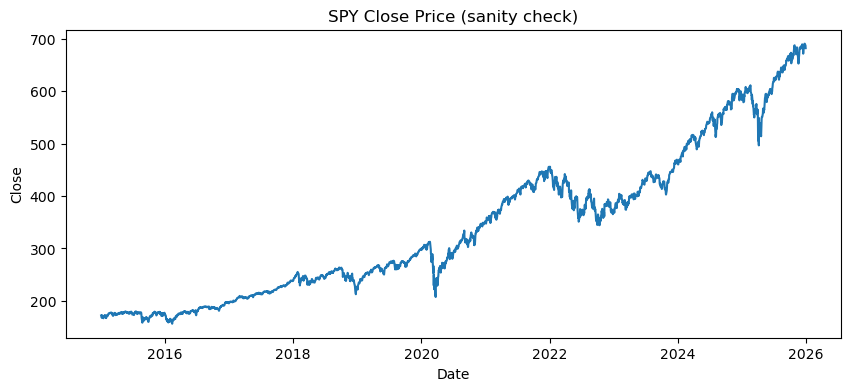

In [25]:
# Quick plot: closing price for first ticker
t0 = cfg.tickers[0]
tmp = prices.loc[prices["ticker"] == t0].copy()

plt.figure(figsize=(10, 4))
plt.plot(tmp["date"], tmp["close"])
plt.title(f"{t0} Close Price (sanity check)")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

## 3. Labeling price outcomes with the Triple-Barrier method

### 3.1 Label definition (Up / Down / Hold)
In this section, I will create the target label for each trading day. For each date t, I'll treat the close price as the “entry” price, then look forward a fixed number of trading days (the horizon). If price hits the profit-take barrier first, I label it Up. If price hits the stop-loss barrier first, I label it Down. If neither barrier is hit within the horizon, I label it Hold. This gives me a simple 3-class prediction problem that matches how traders often think: up move, down move, or no clear move.

In [28]:
LABEL_MAP = {1: "Up", 0: "Hold", -1: "Down"}

def triple_barrier_label_one(
    highs: np.ndarray,
    lows: np.ndarray,
    closes: np.ndarray,
    dates: np.ndarray,
    i: int,
    horizon: int,
    pt: float,
    sl: float
):
    """
    Label a single index i using a fixed-horizon triple-barrier approach.

    Entry price = close[i]
    Profit take barrier = entry * (1 + pt)
    Stop loss barrier   = entry * (1 - sl)

    Decision:
      - If PT is hit first => label = 1
      - If SL is hit first => label = -1
      - If neither hit within horizon => label = 0
      - If both hit on the same day => label = 0 (ambiguous intraday ordering)

    Returns: (label_int, event_date, event_type)
    """
    entry = closes[i]
    if not np.isfinite(entry) or entry <= 0:
        return (np.nan, pd.NaT, "bad_entry")

    pt_price = entry * (1 + pt)
    sl_price = entry * (1 - sl)

    # Look forward 1..horizon days
    end = min(i + horizon, len(closes) - 1)

    pt_hit = None
    sl_hit = None

    for j in range(i + 1, end + 1):
        if pt_hit is None and highs[j] >= pt_price:
            pt_hit = j
        if sl_hit is None and lows[j] <= sl_price:
            sl_hit = j

        # If we already found both hits, we can stop early
        if pt_hit is not None and sl_hit is not None:
            break

    # Decide outcome
    if pt_hit is None and sl_hit is None:
        return (0, dates[end], "time_exit")  # neither hit within horizon
    if pt_hit is not None and sl_hit is None:
        return (1, dates[pt_hit], "pt_first")
    if sl_hit is not None and pt_hit is None:
        return (-1, dates[sl_hit], "sl_first")

    # Both were hit: compare which day happened first
    if pt_hit < sl_hit:
        return (1, dates[pt_hit], "pt_first")
    if sl_hit < pt_hit:
        return (-1, dates[sl_hit], "sl_first")

    # Same day hit both barriers (ambiguous intraday order)
    return (0, dates[pt_hit], "both_same_day")

### 3.2 Apply triple-barrier labels per ticker
In this section, I will apply the labeling function to each ticker separately (so there is no cross-ticker leakage). I will also drop the final horizon_days rows per ticker because they do not have enough future data to form a label.

In [30]:
def add_triple_barrier_labels(df_one: pd.DataFrame, horizon: int, pt: float, sl: float) -> pd.DataFrame:
    df_one = df_one.sort_values("date").reset_index(drop=True).copy()

    highs = df_one["high"].to_numpy(dtype=float)
    lows = df_one["low"].to_numpy(dtype=float)
    closes = df_one["close"].to_numpy(dtype=float)
    dates = df_one["date"].to_numpy()

    labels = []
    event_dates = []
    event_types = []

    n = len(df_one)
    max_i = n - horizon - 1  # last index that has a full horizon

    for i in range(n):
        if i > max_i:
            labels.append(np.nan)
            event_dates.append(pd.NaT)
            event_types.append("insufficient_future")
            continue

        lab, edate, etype = triple_barrier_label_one(
            highs, lows, closes, dates,
            i=i, horizon=horizon, pt=pt, sl=sl
        )
        labels.append(lab)
        event_dates.append(edate)
        event_types.append(etype)

    df_one["label"] = labels
    df_one["label_name"] = df_one["label"].map(LABEL_MAP)
    df_one["event_date"] = pd.to_datetime(event_dates)
    df_one["event_type"] = event_types

    # Optional realized return at horizon end (useful for later diagnostics)
    df_one["ret_horizon"] = df_one["close"].shift(-horizon) / df_one["close"] - 1

    # Drop rows without labels
    df_one = df_one.dropna(subset=["label"]).reset_index(drop=True)
    df_one["label"] = df_one["label"].astype(int)
    return df_one


labeled_list = []
for t in cfg.tickers:
    df_t = prices.loc[prices["ticker"] == t].copy()
    df_t_lab = add_triple_barrier_labels(
        df_t,
        horizon=cfg.horizon_days,
        pt=cfg.pt_return,
        sl=cfg.sl_return
    )
    labeled_list.append(df_t_lab)
    print(f"{t}: labeled rows = {len(df_t_lab):,}")

labeled = pd.concat(labeled_list, ignore_index=True).sort_values(["ticker", "date"]).reset_index(drop=True)
print("Total labeled rows:", len(labeled))
labeled.head()

SPY: labeled rows = 2,746
AAPL: labeled rows = 2,746
MSFT: labeled rows = 2,746
NVDA: labeled rows = 2,746
Total labeled rows: 10984


,date,open,high,low,close,volume,ticker,label,label_name,event_date,event_type,ret_horizon
0,2015-01-02,24.6921,24.7037,23.8002,24.2374,239959065.0,AAPL,1,Up,2015-01-28,pt_first,0.084968
1,2015-01-05,24.0036,24.0802,23.3700,23.5555,289848502.0,AAPL,1,Up,2015-01-08,pt_first,0.116588
2,2015-01-06,23.6461,23.8160,23.1942,23.5575,296598610.0,AAPL,1,Up,2015-01-08,pt_first,0.124920
3,2015-01-07,23.7688,23.9820,23.6510,23.8917,180725843.0,AAPL,1,Up,2015-01-09,pt_first,0.117313
4,2015-01-08,24.2155,24.8669,24.0929,24.8079,267640572.0,AAPL,-1,Down,2015-01-16,sl_first,0.066709


### 3.3 Check class balance and labeling sanity
In this section, I will check whether the dataset is heavily imbalanced (for example, too many Hold labels). This matters because a model can look “accurate” simply by predicting the most common class.

In [32]:
# Overall class distribution
overall_counts = labeled["label_name"].value_counts()
overall_pct = (overall_counts / overall_counts.sum() * 100).round(2)

print("Overall label counts:")
display(pd.DataFrame({"count": overall_counts, "pct_%": overall_pct}))

# Per-ticker distribution
per_ticker = (labeled.groupby(["ticker", "label_name"])
              .size()
              .unstack(fill_value=0)
              .sort_index())

display(per_ticker)

Overall label counts:


,count,pct_%
label_name,,
Up,4825,43.93
Down,3361,30.60
Hold,2798,25.47


label_name,Down,Hold,Up
ticker,,,
AAPL,934,396,1416
MSFT,814,610,1322
NVDA,1114,63,1569
SPY,499,1729,518


Overall, the triple-barrier labeling produced a fairly balanced three-class target, with **Up** as the most common outcome (4,825 observations, 43.93%), followed by **Down** (3,361 observations, 30.60%) and **Hold** (2,798 observations, 25.47%). This distribution suggests the labels are not dominated by a single class, which is helpful because it reduces the chance that a model looks “good” simply by always predicting one outcome. At the ticker level, the label mix is noticeably different across assets: **SPY** has a large share of **Hold** outcomes (1,729 Hold vs. 518 Up and 499 Down), which is consistent with an index ETF that tends to move more slowly relative to a fixed ±5% barrier over a 20-day horizon. In contrast, **NVDA** has very few **Hold** labels (only 63), meaning it frequently hits either the profit-take or stop-loss barrier within the horizon; this pattern is consistent with higher volatility and larger price swings. **AAPL** and **MSFT** fall between these extremes, with a moderate number of Hold outcomes and more frequent Up moves than Down moves. Overall, this class balance and the cross-ticker differences look reasonable and reflect different volatility profiles across the selected assets.

In [34]:
# Simple baseline: always predict the majority class
majority_class = labeled["label_name"].value_counts().idxmax()
majority_acc = (labeled["label_name"] == majority_class).mean()

print(f"Majority class = {majority_class}")
print(f"Majority-class baseline accuracy = {majority_acc:.3f}")

Majority class = Up
Majority-class baseline accuracy = 0.439


In [35]:
# Quick look at event types (helps diagnose how often "time_exit" happens)
event_type_counts = labeled["event_type"].value_counts().head(10)
display(event_type_counts)

event_type
pt_first         4825
sl_first         3361
time_exit        2790
both_same_day       8
Name: count, dtype: int64

In [36]:
# One-ticker sanity check: show a small slice
t0 = cfg.tickers[0]
sample = labeled.loc[labeled["ticker"] == t0, ["date", "close", "label_name", "event_date", "event_type", "ret_horizon"]].tail(10)
sample

,date,close,label_name,event_date,event_type,ret_horizon
10974,2025-11-18,660.08,Hold,2025-12-17,time_exit,0.017149
10975,2025-11-19,662.63,Hold,2025-12-18,time_exit,0.020886
10976,2025-11-20,652.53,Up,2025-12-04,pt_first,0.043002
10977,2025-11-21,659.03,Hold,2025-12-22,time_exit,0.039148
10978,2025-11-24,668.73,Hold,2025-12-23,time_exit,0.028756
10979,2025-11-25,675.02,Hold,2025-12-24,time_exit,0.022755
10980,2025-11-26,679.68,Hold,2025-12-26,time_exit,0.015640
10981,2025-11-28,683.39,Hold,2025-12-29,time_exit,0.006526
10982,2025-12-01,680.27,Hold,2025-12-30,time_exit,0.009908
10983,2025-12-02,681.53,Hold,2025-12-31,time_exit,0.000572


The majority class in the labeled dataset is **Up**, so a naïve model that always predicts Up would achieve about **43.9% accuracy**. This provides a simple baseline to beat and confirms the task is not trivial. The event-type breakdown also looks consistent with how the triple-barrier method is defined: **4,825** observations hit the profit-take barrier first (`pt_first`), **3,361** hit the stop-loss first (`sl_first`), and **2,790** reached the time horizon without hitting either barrier (`time_exit`). Only **8** cases hit both barriers on the same day (`both_same_day`), so ambiguous outcomes are rare and should not materially affect training. The sample rows show how the label aligns with the outcome logic: most **Hold** cases are `time_exit` with relatively small horizon returns, while **Up** cases occur when the profit-take barrier is reached earlier within the window.

## 4. Feature engineering for the multi-modal model (numeric indicators)

### 4.1 Compute technical indicators per ticker
In this section, I will create a small set of numeric indicators that summarize momentum, trend, and volume. These features are intentionally simple and widely used so I can compare whether adding them provides any improvement over the vision-only baseline.

In [40]:
def compute_rsi(close: pd.Series, window: int = 14) -> pd.Series:
    """
    RSI using Wilder-style smoothing via exponential moving averages.
    Output range is roughly 0-100.
    """
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = (-delta).clip(lower=0)

    avg_gain = gain.ewm(alpha=1/window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/window, adjust=False).mean()

    rs = avg_gain / (avg_loss + 1e-12)
    rsi = 100 - (100 / (1 + rs))
    return rsi


def add_numeric_features(df_one: pd.DataFrame) -> pd.DataFrame:
    """
    Add a compact set of numeric indicators for multi-modal learning.
    """
    df = df_one.sort_values("date").reset_index(drop=True).copy()

    # Moving averages
    df["ma_5"] = df["close"].rolling(5).mean()
    df["ma_10"] = df["close"].rolling(10).mean()
    df["ma_20"] = df["close"].rolling(20).mean()

    # Distance to MAs (normalized)
    df["close_over_ma5"] = df["close"] / (df["ma_5"] + 1e-12) - 1
    df["close_over_ma10"] = df["close"] / (df["ma_10"] + 1e-12) - 1
    df["close_over_ma20"] = df["close"] / (df["ma_20"] + 1e-12) - 1

    # RSI
    df["rsi_14"] = compute_rsi(df["close"], window=14)

    # Volume ratio vs 20-day average
    df["vol_ma20"] = df["volume"].rolling(20).mean()
    df["vol_ratio20"] = df["volume"] / (df["vol_ma20"] + 1e-12)

    # Optional simple 1-day return (can help multi-modal)
    df["ret_1d"] = df["close"].pct_change()

    return df

### 4.2 Apply features to the labeled dataset
In this section, I will compute numeric indicators for each ticker and merge them back with the triple-barrier labels. I will then drop early rows where rolling indicators do not exist yet (NaNs).

In [42]:
featured_list = []
for t in cfg.tickers:
    df_t = labeled.loc[labeled["ticker"] == t].copy()
    df_t = add_numeric_features(df_t)
    featured_list.append(df_t)

featured = pd.concat(featured_list, ignore_index=True).sort_values(["ticker", "date"]).reset_index(drop=True)
print("Rows before dropping NaNs:", len(featured))

# Choose numeric feature columns
num_features = [
    "close_over_ma5", "close_over_ma10", "close_over_ma20",
    "rsi_14", "vol_ratio20", "ret_1d"
]

# Drop rows where features are missing (due to rolling windows)
featured = featured.dropna(subset=num_features).reset_index(drop=True)
print("Rows after dropping NaNs:", len(featured))

featured[["date", "ticker", "label_name"] + num_features].head()

Rows before dropping NaNs: 10984
Rows after dropping NaNs: 10908


,date,ticker,label_name,close_over_ma5,close_over_ma10,close_over_ma20,rsi_14,vol_ratio20,ret_1d
0,2015-01-30,AAPL,Up,0.021339,0.043165,0.059002,44.093935,1.221371,-0.014679
1,2015-02-02,AAPL,Up,0.024063,0.044265,0.067570,46.494117,0.907806,0.012323
2,2015-02-03,AAPL,Up,0.007708,0.035402,0.061853,46.532731,0.758814,0.000190
3,2015-02-04,AAPL,Up,0.008081,0.034219,0.063549,48.133050,1.021418,0.007547
4,2015-02-05,AAPL,Up,0.012919,0.034624,0.065351,49.718669,0.612236,0.007328


### 4.3 Quick sanity checks on features
In this section, I will confirm feature ranges and make sure there are no obvious issues (such as infinite values).

In [44]:
# Basic stats
stats = featured[num_features].describe().T
stats

,count,mean,std,min,25%,50%,75%,max
close_over_ma5,10908.0,0.002336,0.021365,-0.203161,-0.006936,0.002822,0.012211,0.194775
close_over_ma10,10908.0,0.005279,0.032382,-0.251800,-0.009204,0.005881,0.020297,0.234397
close_over_ma20,10908.0,0.011227,0.047544,-0.277349,-0.011324,0.011973,0.033351,0.301239
rsi_14,10908.0,55.801711,12.113105,17.049042,47.204968,56.318522,64.678396,90.730048
vol_ratio20,10908.0,1.005711,0.378838,0.195442,0.769811,0.922367,1.137531,5.787254
ret_1d,10908.0,0.001342,0.020570,-0.187536,-0.006825,0.001109,0.009871,0.298012


In [45]:
# Check for inf values
inf_counts = np.isinf(featured[num_features]).sum()
inf_counts

close_over_ma5     0
close_over_ma10    0
close_over_ma20    0
rsi_14             0
vol_ratio20        0
ret_1d             0
dtype: int64

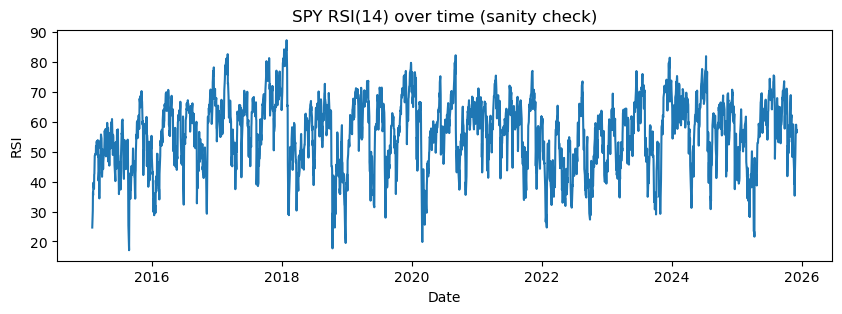

In [46]:
# Example plot: RSI for one ticker
t0 = cfg.tickers[0]
tmp = featured.loc[featured["ticker"] == t0].copy()

plt.figure(figsize=(10, 3))
plt.plot(tmp["date"], tmp["rsi_14"])
plt.title(f"{t0} RSI(14) over time (sanity check)")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.show()

After computing the numeric indicators, I started with **10,984** labeled rows and ended with **10,908** rows after dropping early dates where rolling features (moving averages, RSI, and 20-day volume average) are not yet available. The engineered features look reasonable: the “close vs. moving average” signals are centered near zero (meaning price is usually close to its recent averages), **RSI(14)** stays mostly in a realistic range (about **17 to 91**) with an average near the mid-50s, and the **20-day volume ratio** averages around 1.0 with occasional spikes (up to about **5.8**), which is expected during high-volume days. I also confirmed there are **no infinite values** in any feature columns, and the RSI plot over time shows normal oscillations rather than drifting or exploding, which suggests the feature calculations are stable and ready for modeling.

### 4.4 Save a modeling table (optional but helpful)
In this section, I will save the prepared dataset to disk so later steps can reload it quickly.

In [48]:
out_path = DATA_DIR / "labeled_with_features.csv"
featured.to_csv(out_path, index=False)
print("Saved:", relpath(out_path))

Saved: artifacts_project2/data/labeled_with_features.csv


## 5. Candlestick chart image generation
In this section I will (1) create a chart image for each (ticker, date) sample and (2) build an index table linking image_path + label + numeric features for modeling.

### 5.1 Build a lookback window for each sample date
In this section, I will generate one candlestick image per labeled sample. Each image uses the previous lookback_days of OHLCV data ending on the decision day t, so it represents what would have been visible at that time.

I will use the full raw price history (prices) instead of the feature-trimmed table (featured) because the feature table has already dropped early rows where rolling indicators aren’t available (like the first ~20 days). If I used featured to build the candlestick window, some dates would be missing even though the underlying OHLCV data exists, and that would cause windows to fail or become shorter than expected. In other words, I want each image to reflect the true 60 trading days of OHLCV ending on date t.

In [84]:
from matplotlib.patches import Rectangle
from PIL import Image
import time

# Optional speed control to generate fewer images per ticker for debugging
MAX_IMAGES_PER_TICKER = None  # I will just set to None here for full run

def get_lookback_window(prices_t: pd.DataFrame, end_date: pd.Timestamp, lookback: int) -> pd.DataFrame | None:
    """
    Return a lookback window ending at end_date (inclusive).
    Uses the full raw price history (prices), not the feature-trimmed table.
    """
    df = prices_t.sort_values("date").reset_index(drop=True)
    # Find end index
    idx = df.index[df["date"] == end_date]
    if len(idx) == 0:
        return None
    end_i = int(idx[0])
    start_i = end_i - lookback + 1
    if start_i < 0:
        return None
    return df.loc[start_i:end_i, ["date", "open", "high", "low", "close", "volume"]].reset_index(drop=True)

### 5.2 Render and save a candlestick image
In this section, I will convert an OHLCV window into a fixed-size PNG image. I'll remove axes and labels so the model focuses on the price pattern rather than text.

In [102]:
def render_candlestick_image(
    window: pd.DataFrame,
    out_path: Path,
    img_size: int = 224,
    dpi: int = 100,
    include_volume: bool = True
) -> None:
    out_path.parent.mkdir(parents=True, exist_ok=True)

    o = window["open"].to_numpy(float)
    h = window["high"].to_numpy(float)
    l = window["low"].to_numpy(float)
    c = window["close"].to_numpy(float)
    v = window["volume"].to_numpy(float)

    n = len(window)
    x = np.arange(n)

    fig = plt.figure(figsize=(img_size / dpi, img_size / dpi), dpi=dpi, facecolor="white")

    if include_volume:
        ax_price = fig.add_axes([0.0, 0.25, 1.0, 0.75])
        ax_vol = fig.add_axes([0.0, 0.0, 1.0, 0.25], sharex=ax_price)
    else:
        ax_price = fig.add_axes([0.0, 0.0, 1.0, 1.0])
        ax_vol = None

    width = 0.6
    for i in range(n):
        up = c[i] >= o[i]
        color = "green" if up else "red"

        # Wick (match candle color)
        ax_price.vlines(x[i], l[i], h[i], color=color, linewidth=1)

        # Body
        bottom = min(o[i], c[i])
        height = abs(c[i] - o[i])
        if height < 1e-9:
            height = 1e-9

        rect = Rectangle(
            (x[i] - width/2, bottom),
            width,
            height,
            facecolor=color,
            edgecolor=color,
            linewidth=1
        )
        ax_price.add_patch(rect)

        # Volume bar (match candle color)
        if ax_vol is not None:
            ax_vol.bar(x[i], v[i], width=0.8, align="center", color=color)

    # Style
    ax_price.set_axis_off()
    ax_price.set_xlim(-0.5, n - 0.5)
    ymin = np.nanmin(l) * 0.995
    ymax = np.nanmax(h) * 1.005
    ax_price.set_ylim(ymin, ymax)

    if ax_vol is not None:
        ax_vol.set_axis_off()
        ax_vol.set_xlim(-0.5, n - 0.5)
        vmax = np.nanmax(v) if np.isfinite(np.nanmax(v)) else 1.0
        ax_vol.set_ylim(0, vmax * 1.05)

    fig.savefig(out_path, dpi=dpi, pad_inches=0)
    plt.close(fig)

### 5.3 Generate images for all samples and build an index table
In this section, I will create one image per row in featured and store the relative path in a modeling table. **This table will be the “bridge” between the image files and the labels/features**.

In [104]:
# Build per-ticker raw price tables for windowing
prices_by_ticker = {
    t: prices.loc[prices["ticker"] == t].copy().sort_values("date").reset_index(drop=True)
    for t in cfg.tickers
}

# Output index rows
index_rows = []
start_time = time.time()

for t in cfg.tickers:
    df_feat_t = featured.loc[featured["ticker"] == t].copy().sort_values("date").reset_index(drop=True)

    if MAX_IMAGES_PER_TICKER is not None:
        df_feat_t = df_feat_t.tail(MAX_IMAGES_PER_TICKER).reset_index(drop=True)

    generated = 0
    skipped = 0

    for _, row in df_feat_t.iterrows():
        d = pd.to_datetime(row["date"])

        window = get_lookback_window(prices_by_ticker[t], d, cfg.lookback_days)
        if window is None:
            skipped += 1
            continue

        # Save under images/<TICKER>/YYYYMMDD.png
        out_path = IMG_DIR / t / f"{d.strftime('%Y%m%d')}.png"

        if not out_path.exists():
            render_candlestick_image(
                window=window,
                out_path=out_path,
                img_size=cfg.img_size,
                dpi=cfg.dpi,
                include_volume=cfg.include_volume_panel
            )
            generated += 1

        index_rows.append({
            "ticker": t,
            "date": d,
            "label": int(row["label"]),
            "label_name": row["label_name"],
            "image_path": str(relpath(out_path)),
            **{f: float(row[f]) for f in num_features}
        })

    print(f"[{t}] images generated: {generated:,} | skipped (no lookback): {skipped:,} | total indexed: {len(df_feat_t) - skipped:,}")

samples_index = pd.DataFrame(index_rows).sort_values(["ticker", "date"]).reset_index(drop=True)

elapsed = time.time() - start_time
print(f"Index rows: {len(samples_index):,} | elapsed: {elapsed:.1f}s")

samples_index.head()

[SPY] images generated: 2,687 | skipped (no lookback): 40 | total indexed: 2,687
[AAPL] images generated: 2,687 | skipped (no lookback): 40 | total indexed: 2,687
[MSFT] images generated: 2,687 | skipped (no lookback): 40 | total indexed: 2,687
[NVDA] images generated: 2,687 | skipped (no lookback): 40 | total indexed: 2,687
Index rows: 10,748 | elapsed: 640.1s


,ticker,date,label,label_name,image_path,close_over_ma5,close_over_ma10,close_over_ma20,rsi_14,vol_ratio20,ret_1d
0,AAPL,2015-03-30,1,Up,artifacts_project2/images/AAPL/20150330.png,0.012643,0.002858,0.004378,51.851325,0.898441,0.025237
1,AAPL,2015-03-31,1,Up,artifacts_project2/images/AAPL/20150331.png,0.000719,-0.010502,-0.009099,47.283883,0.799631,-0.015360
2,AAPL,2015-04-01,1,Up,artifacts_project2/images/AAPL/20150401.png,-0.002071,-0.008590,-0.008816,46.878298,0.765211,-0.001423
3,AAPL,2015-04-02,1,Up,artifacts_project2/images/AAPL/20150402.png,0.004759,0.001679,0.000137,49.681360,0.621166,0.008592
4,AAPL,2015-04-06,1,Up,artifacts_project2/images/AAPL/20150406.png,0.014328,0.016685,0.015972,54.569693,0.742572,0.016131


### 5.4 Sanity check: confirm image size and preview a few samples
In this section, I will verify that the saved images have the expected pixel size and visually inspect a few examples.

In [106]:
# Check one sample image size
p0 = Path(samples_index.loc[0, "image_path"])
img0 = Image.open(p0)
print("First image relative path:", samples_index.loc[0, "image_path"])
print("Image size (W, H):", img0.size)
img0.close()

First image relative path: artifacts_project2/images/AAPL/20150330.png
Image size (W, H): (224, 224)


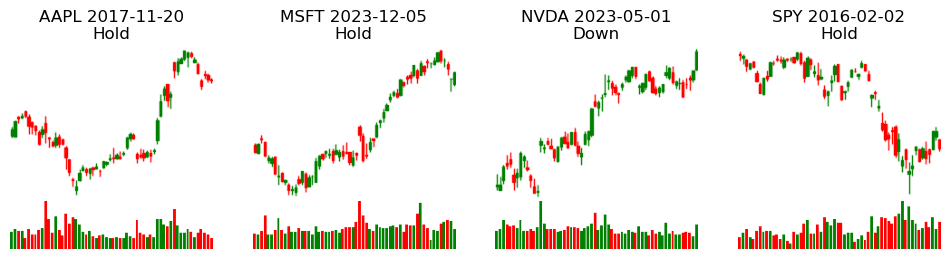

In [108]:
# Preview a few random images
show_n = 4
sample_rows = samples_index.sample(show_n, random_state=SEED)

plt.figure(figsize=(12, 3))
for i, (_, r) in enumerate(sample_rows.iterrows(), start=1):
    p = Path(r["image_path"])
    im = Image.open(p)
    ax = plt.subplot(1, show_n, i)
    ax.imshow(im)
    ax.set_title(f"{r['ticker']} {r['date'].date()}\n{r['label_name']}")
    ax.axis("off")
    im.close()
plt.show()

The candlestick images were generated successfully and look consistent across tickers and dates. Each sample uses a fixed lookback window and is saved as a standardized **224×224** PNG, which makes the dataset ready for CNN training without additional resizing. The visual encoding matches common charting conventions: candles (and volume bars) are colored **green when close ≥ open** and **red when close < open**, so the direction of each day’s move is easy to interpret and consistent across all images. The preview examples show clear price patterns and properly aligned volume panels, suggesting the rendering pipeline is working as intended and producing usable inputs for the vision-only and multi-modal models.

### 5.5 Save the index table

In [111]:
index_path = DATA_DIR / "samples_index.csv"
samples_index.to_csv(index_path, index=False)
print("Saved:", relpath(index_path))

Saved: artifacts_project2/data/samples_index.csv


## 6. Time-based splits and PyTorch data loaders (vision-only baseline)

### 6.1 Prepare the modeling table
In this section, I will convert the triple-barrier labels into a simple 0/1/2 class ID for PyTorch classification (CrossEntropyLoss expects class indices starting at 0). I will also do a quick check that all image paths exist.

In [116]:
# Map {-1,0,1} -> {0,1,2} for CrossEntropyLoss
LABEL_TO_CLASS = {-1: 0, 0: 1, 1: 2}
CLASS_TO_NAME = {0: "Down", 1: "Hold", 2: "Up"}

samples = samples_index.copy()
samples["y_class"] = samples["label"].map(LABEL_TO_CLASS).astype(int)

# Confirm image files exist
missing_imgs = (~samples["image_path"].apply(lambda p: Path(p).exists())).sum()
print("Missing image files:", int(missing_imgs))

samples.head()

Missing image files: 0


,ticker,date,label,label_name,image_path,close_over_ma5,close_over_ma10,close_over_ma20,rsi_14,vol_ratio20,ret_1d,y_class
0,AAPL,2015-03-30,1,Up,artifacts_project2/images/AAPL/20150330.png,0.012643,0.002858,0.004378,51.851325,0.898441,0.025237,2
1,AAPL,2015-03-31,1,Up,artifacts_project2/images/AAPL/20150331.png,0.000719,-0.010502,-0.009099,47.283883,0.799631,-0.015360,2
2,AAPL,2015-04-01,1,Up,artifacts_project2/images/AAPL/20150401.png,-0.002071,-0.008590,-0.008816,46.878298,0.765211,-0.001423,2
3,AAPL,2015-04-02,1,Up,artifacts_project2/images/AAPL/20150402.png,0.004759,0.001679,0.000137,49.681360,0.621166,0.008592,2
4,AAPL,2015-04-06,1,Up,artifacts_project2/images/AAPL/20150406.png,0.014328,0.016685,0.015972,54.569693,0.742572,0.016131,2


### 6.2 Time-based split (per ticker)
In this section, I will split the data by time to avoid look-ahead bias. I do the split within each ticker (train first, then validation, then test) so each ticker is represented in every split.

In [119]:
def time_split_per_ticker(df: pd.DataFrame, train_frac: float, val_frac: float, test_frac: float) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-6, "Fractions must sum to 1."

    train_parts, val_parts, test_parts = [], [], []

    for t, g in df.groupby("ticker"):
        g = g.sort_values("date").reset_index(drop=True)

        n = len(g)
        n_train = int(n * train_frac)
        n_val = int(n * val_frac)
        n_test = n - n_train - n_val

        train_parts.append(g.iloc[:n_train])
        val_parts.append(g.iloc[n_train:n_train + n_val])
        test_parts.append(g.iloc[n_train + n_val:])

        # Optional quick check per ticker
        # print(t, n_train, n_val, n_test)

    train_df = pd.concat(train_parts, ignore_index=True).sort_values(["ticker", "date"]).reset_index(drop=True)
    val_df   = pd.concat(val_parts, ignore_index=True).sort_values(["ticker", "date"]).reset_index(drop=True)
    test_df  = pd.concat(test_parts, ignore_index=True).sort_values(["ticker", "date"]).reset_index(drop=True)

    return train_df, val_df, test_df


train_df, val_df, test_df = time_split_per_ticker(
    samples,
    train_frac=cfg.train_frac,
    val_frac=cfg.val_frac,
    test_frac=cfg.test_frac
)

print("Rows:", {"train": len(train_df), "val": len(val_df), "test": len(test_df)})
print("Date ranges:",
      "\n  train:", train_df["date"].min().date(), "→", train_df["date"].max().date(),
      "\n  val:  ", val_df["date"].min().date(), "→", val_df["date"].max().date(),
      "\n  test: ", test_df["date"].min().date(), "→", test_df["date"].max().date())

Rows: {'train': 7520, 'val': 1612, 'test': 1616}
Date ranges: 
  train: 2015-03-30 → 2022-09-14 
  val:   2022-09-15 → 2024-04-23 
  test:  2024-04-24 → 2025-12-02


### 6.3 Split sanity checks (class balance)
In this section, I will check class balance inside each split. This helps me interpret results later (for example, if one split is much more “Up-heavy” than another).

In [128]:
def class_summary(df: pd.DataFrame, name: str):
    counts = df["y_class"].value_counts().sort_index()
    pct = (counts / counts.sum() * 100).round(2)
    summary = pd.DataFrame({
        "class_id": counts.index,
        "class_name": [CLASS_TO_NAME[i] for i in counts.index],
        "count": counts.values,
        "pct_%": pct.values
    })
    print(f"\n{name} class distribution:")
    display(summary)

class_summary(train_df, "Train")
class_summary(val_df, "Validation")
class_summary(test_df, "Test")


Train class distribution:


,class_id,class_name,count,pct_%
0,0,Down,2321,30.86
1,1,Hold,1966,26.14
2,2,Up,3233,42.99



Validation class distribution:


,class_id,class_name,count,pct_%
0,0,Down,449,27.85
1,1,Hold,345,21.40
2,2,Up,818,50.74



Test class distribution:


,class_id,class_name,count,pct_%
0,0,Down,516,31.93
1,1,Hold,408,25.25
2,2,Up,692,42.82


### 6.4 Define image transforms
In this section, I will define the preprocessing applied to each image. Since I’m using a ResNet-based model, I'll normalize images using common ImageNet normalization values.

In [126]:
from PIL import Image

# ImageNet normalization (standard for ResNet pretrained backbones)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

eval_transform = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

### 6.5 PyTorch Dataset and DataLoaders (vision-only)
In this section, I will build a Dataset that loads each image from disk and returns (image_tensor, class_label). I will then create DataLoaders for train/validation/test.

In [131]:
class CandleImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img_path = Path(row["image_path"])

        # Load image
        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        y = int(row["y_class"])
        return img, y


train_ds = CandleImageDataset(train_df, transform=train_transform)
val_ds   = CandleImageDataset(val_df, transform=eval_transform)
test_ds  = CandleImageDataset(test_df, transform=eval_transform)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,  num_workers=cfg.num_workers)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
test_loader  = DataLoader(test_ds,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

print("Dataloaders ready:",
      f"train batches={len(train_loader)}, val batches={len(val_loader)}, test batches={len(test_loader)}")

Dataloaders ready: train batches=235, val batches=51, test batches=51


Great, the train batches = 235 means our training set (7,520 samples) will be fed through the model in 235 steps per epoch (roughly 7,520 / 32 ≈ 235).

### 6.6 Quick batch sanity check
In this section, I will pull one batch to confirm shapes and label values look correct.

In [134]:
xb, yb = next(iter(train_loader))
print("Batch X shape:", tuple(xb.shape))  # (B, C, H, W)
print("Batch y shape:", tuple(yb.shape))  # (B,)
print("y min/max:", int(yb.min()), int(yb.max()))
print("Example labels (first 10):", yb[:10].tolist())

Batch X shape: (32, 3, 224, 224)
Batch y shape: (32,)
y min/max: 0 2
Example labels (first 10): [1, 1, 0, 2, 1, 0, 1, 2, 2, 2]


The batch printout above confirms that:
- Batch X shape: (32, 3, 224, 224) → 32 images, 3 color channels (RGB), 224×224 pixels
- Batch y shape: (32,) → 32 labels (Down/Hold/Up mapped to 0/1/2)

The reason we will use batches instead of the whole dataset at once:
- It fits in memory (GPU/CPU RAM) more easily.
- It’s faster and more stable to train.
- Each batch produces one gradient update step.

## 7. Vision-only baseline model (ResNet18)

### 7.1 Define the model (pretrained ResNet18)
In this section, I will train a vision-only baseline using a ResNet18 backbone. The model takes the candlestick image as input and predicts one of three classes (Down/Hold/Up). This baseline helps me measure how much information is learnable from the chart image alone.

In [199]:
from torchvision.models import resnet18, ResNet18_Weights

NUM_CLASSES = 3

def build_resnet18(num_classes: int = 3, use_imagenet_weights: bool = True) -> nn.Module:
    """
    Vision-only baseline using ResNet18.
    Uses the modern torchvision 'weights' API.
    """
    weights = ResNet18_Weights.DEFAULT if use_imagenet_weights else None
    model = resnet18(weights=weights)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

model = build_resnet18(num_classes=NUM_CLASSES, use_imagenet_weights=True).to(device)
print(f"Model ready: ResNet18 → {NUM_CLASSES} classes | device={device}")

Model ready: ResNet18 → 3 classes | device=mps


### 7.2 Loss function (with class weights) and optimizer
In this section, I will use class weights to reduce the impact of class imbalance (Up is more common). This makes the loss penalize minority-class mistakes more fairly.

In [201]:
# Compute class weights from train split: weight_k = total / (K * count_k)
train_counts = train_df["y_class"].value_counts().sort_index()
total = train_counts.sum()
class_weights = (total / (NUM_CLASSES * train_counts)).to_numpy(dtype=np.float32)

weights_tensor = torch.tensor(class_weights, device=device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

print("Loss/optimizer ready.")

Loss/optimizer ready.


### 7.3 Train and validate
In this section, I will train for a 15 number of epochs and select the best model based on validation accuracy. I'll log only one short line per epoch to keep notebook output clean.

In [216]:
def run_epoch(loader, model, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss = 0.0
    correct = 0
    n = 0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device, dtype=torch.long)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            logits = model(xb)
            loss = criterion(logits, yb)

            if is_train:
                loss.backward()
                optimizer.step()

        total_loss += float(loss.item()) * xb.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += int((preds == yb).sum().item())
        n += xb.size(0)

    avg_loss = total_loss / max(n, 1)
    acc = correct / max(n, 1)
    return avg_loss, acc


best_val_acc = -1.0
best_path = MODEL_DIR / "resnet18_vision_only_best.pt"

history = []

for epoch in range(1, cfg.epochs + 1):
    tr_loss, tr_acc = run_epoch(train_loader, model, criterion, optimizer=optimizer)
    va_loss, va_acc = run_epoch(val_loader, model, criterion, optimizer=None)

    history.append({
        "epoch": epoch,
        "train_loss": tr_loss, "train_acc": tr_acc,
        "val_loss": va_loss, "val_acc": va_acc
    })

    # Minimal one-line log
    print(f"Epoch {epoch}/{cfg.epochs} | train acc={tr_acc:.3f}, loss={tr_loss:.3f} | val acc={va_acc:.3f}, loss={va_loss:.3f}")

    # Save best
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), best_path)

print(f"Best val acc={best_val_acc:.3f} | saved={relpath(best_path)}")

Epoch 1/15 | train acc=0.984, loss=0.049 | val acc=0.455, loss=2.519
Epoch 2/15 | train acc=0.987, loss=0.041 | val acc=0.448, loss=2.676
Epoch 3/15 | train acc=0.986, loss=0.042 | val acc=0.391, loss=3.260
Epoch 4/15 | train acc=0.986, loss=0.044 | val acc=0.471, loss=2.621
Epoch 5/15 | train acc=0.989, loss=0.037 | val acc=0.445, loss=2.677
Epoch 6/15 | train acc=0.994, loss=0.019 | val acc=0.434, loss=2.694
Epoch 7/15 | train acc=0.997, loss=0.009 | val acc=0.421, loss=3.022
Epoch 8/15 | train acc=0.995, loss=0.016 | val acc=0.411, loss=2.884
Epoch 9/15 | train acc=0.988, loss=0.038 | val acc=0.484, loss=2.725
Epoch 10/15 | train acc=0.978, loss=0.058 | val acc=0.440, loss=2.832
Epoch 11/15 | train acc=0.987, loss=0.039 | val acc=0.480, loss=2.977
Epoch 12/15 | train acc=0.990, loss=0.024 | val acc=0.416, loss=3.111
Epoch 13/15 | train acc=0.994, loss=0.018 | val acc=0.445, loss=2.900
Epoch 14/15 | train acc=0.996, loss=0.013 | val acc=0.445, loss=2.957
Epoch 15/15 | train acc=0.997

### 7.4 Evaluate on the test set
In this section, I will load the best checkpoint and evaluate on the test set. I will report accuracy and macro F1 (macro F1 treats each class equally).

In [219]:
# Load best model and run inference on test set
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device, dtype=torch.long)

        logits = model(xb)
        preds = torch.argmax(logits, dim=1)

        y_true.extend(yb.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

test_acc = (y_true == y_pred).mean()
test_f1_macro = f1_score(y_true, y_pred, average="macro")

print(f"Test results | acc={test_acc:.3f} | macro_f1={test_f1_macro:.3f}")

Test results | acc=0.452 | macro_f1=0.447


In [221]:
# Full classification report
from sklearn.metrics import classification_report

report_dict = classification_report(
    y_true, y_pred,
    target_names=[CLASS_TO_NAME[i] for i in range(3)],
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report_dict).T

display(report_df.round(3))

,precision,recall,f1-score,support
Down,0.412,0.328,0.365,516.000
Hold,0.452,0.537,0.490,408.000
Up,0.476,0.496,0.485,692.000
accuracy,0.452,0.452,0.452,0.452
macro avg,0.446,0.453,0.447,1616.000
weighted avg,0.449,0.452,0.448,1616.000


In [223]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
cm_df = pd.DataFrame(
    cm,
    index=[f"True {CLASS_TO_NAME[i]}" for i in range(3)],
    columns=[f"Pred {CLASS_TO_NAME[i]}" for i in range(3)]
)

display(cm_df)

,Pred Down,Pred Hold,Pred Up
True Down,169,123,224
True Hold,35,219,154
True Up,206,143,343


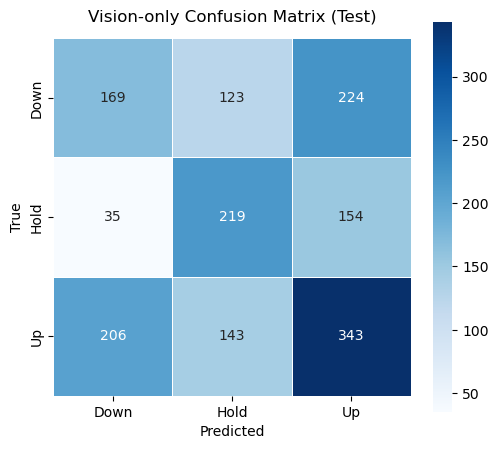

In [225]:
# Visual confusion matrix
plt.figure(figsize=(5.2, 4.6))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[CLASS_TO_NAME[i] for i in range(3)],
    yticklabels=[CLASS_TO_NAME[i] for i in range(3)],
    cbar=True,
    square=True,
    linewidths=0.5,
    linecolor="white"
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Vision-only Confusion Matrix (Test)", pad=12)
plt.tight_layout()
plt.show()

Training the vision-only ResNet18 baseline again produced very high training accuracy throughout the 15 epochs (roughly **0.98–1.00**), while validation accuracy stayed much lower and peaked at **0.484**. This consistent gap indicates the model fits the training period extremely well but does not generalize as strongly to later time periods, which suggests overfitting (or that chart-only signals are limited for this task). Using the best validation checkpoint, test performance was **0.452 accuracy** with **0.447 macro F1**, which is only slightly above the majority-class baseline (~0.439) and notably weaker than the earlier run’s test accuracy. Class-level metrics show the model is more balanced across classes in this run but still imperfect: **Down** improved in recall (**0.328**) compared with the previous run, but overall performance remains modest with F1 scores around **0.37–0.49** across the three classes. The confusion matrix shows the model still confuses directions frequently, especially between **Down and Up** (for example, many true Down cases are predicted as Up and many true Up cases are predicted as Down), which suggests the vision-only approach struggles to separate upside vs. downside patterns reliably.

## 8. Multi-modal model (candlestick image + numeric indicators)
For this section 8 I will reuse:
- the same samples_index table,
- the same time splits (train_df, val_df, test_df),
- the same image transforms,
- the same training loop structure.

I'll only add: numeric feature scaling, a multi-input Dataset, and a fusion model.

### 8.1 Prepare numeric features and scale using train-only statistics

In [230]:
# Numeric feature columns (already in samples_index)
num_features = [
    "close_over_ma5", "close_over_ma10", "close_over_ma20",
    "rsi_14", "vol_ratio20", "ret_1d"
]

def fit_standardizer(df: pd.DataFrame, cols: list[str]):
    mu = df[cols].mean()
    sigma = df[cols].std().replace(0, 1.0)
    return mu, sigma

def apply_standardizer(df: pd.DataFrame, cols: list[str], mu: pd.Series, sigma: pd.Series) -> pd.DataFrame:
    out = df.copy()
    out[cols] = (out[cols] - mu) / sigma
    return out

# Fit on TRAIN only to avoid leakage
mu, sigma = fit_standardizer(train_df, num_features)

train_mm = apply_standardizer(train_df, num_features, mu, sigma)
val_mm   = apply_standardizer(val_df,   num_features, mu, sigma)
test_mm  = apply_standardizer(test_df,  num_features, mu, sigma)

print("Multi-modal tables ready.")

Multi-modal tables ready.


### 8.2 Multi-modal Dataset and DataLoaders

In [233]:
class CandleMultiModalDataset(Dataset):
    def __init__(self, df: pd.DataFrame, num_cols: list[str], transform=None):
        self.df = df.reset_index(drop=True)
        self.num_cols = num_cols
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]

        # Image
        img = Image.open(Path(row["image_path"])).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        # Numeric features
        x_num = torch.tensor(row[self.num_cols].to_numpy(dtype=np.float32), dtype=torch.float32)

        # Label
        y = int(row["y_class"])
        return img, x_num, y


train_ds_mm = CandleMultiModalDataset(train_mm, num_features, transform=train_transform)
val_ds_mm   = CandleMultiModalDataset(val_mm,   num_features, transform=eval_transform)
test_ds_mm  = CandleMultiModalDataset(test_mm,  num_features, transform=eval_transform)

train_loader_mm = DataLoader(train_ds_mm, batch_size=cfg.batch_size, shuffle=True,  num_workers=cfg.num_workers)
val_loader_mm   = DataLoader(val_ds_mm,   batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
test_loader_mm  = DataLoader(test_ds_mm,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

print("Multi-modal dataloaders ready.")

Multi-modal dataloaders ready.


### 8.3 Define the fusion model (ResNet18 + numeric MLP)

In [238]:
from torchvision.models import resnet18, ResNet18_Weights

class MultiModalResNet(nn.Module):
    def __init__(self, num_numeric: int, num_classes: int = 3, use_imagenet_weights: bool = True):
        super().__init__()

        # Vision backbone (modern torchvision weights API)
        weights = ResNet18_Weights.DEFAULT if use_imagenet_weights else None
        self.backbone = resnet18(weights=weights)

        feat_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # output: (B, feat_dim)

        # Numeric branch
        self.num_mlp = nn.Sequential(
            nn.Linear(num_numeric, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 32),
            nn.ReLU()
        )

        # Fusion head
        self.head = nn.Sequential(
            nn.Linear(feat_dim + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x_img, x_num):
        v = self.backbone(x_img)
        n = self.num_mlp(x_num)
        z = torch.cat([v, n], dim=1)
        return self.head(z)

mm_model = MultiModalResNet(
    num_numeric=len(num_features),
    num_classes=3,
    use_imagenet_weights=True
).to(device)

print(f"Multi-modal model ready | device={device}")

Multi-modal model ready | device=mps


### 8.4 Loss, optimizer, training loop

In [241]:
# Reuse class weights from train split
train_counts = train_df["y_class"].value_counts().sort_index()
total = train_counts.sum()
class_weights = (total / (3 * train_counts)).to_numpy(dtype=np.float32)
weights_tensor = torch.tensor(class_weights, device=device)

criterion_mm = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer_mm = torch.optim.AdamW(mm_model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

def run_epoch_mm(loader, model, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss = 0.0
    correct = 0
    n = 0

    for xb, xnum, yb in loader:
        xb = xb.to(device)
        xnum = xnum.to(device)
        yb = yb.to(device, dtype=torch.long)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            logits = model(xb, xnum)
            loss = criterion(logits, yb)

            if is_train:
                loss.backward()
                optimizer.step()

        total_loss += float(loss.item()) * xb.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += int((preds == yb).sum().item())
        n += xb.size(0)

    return (total_loss / max(n, 1)), (correct / max(n, 1))


best_val_acc = -1.0
best_path_mm = MODEL_DIR / "resnet18_multimodal_best.pt"

for epoch in range(1, cfg.epochs + 1):
    tr_loss, tr_acc = run_epoch_mm(train_loader_mm, mm_model, criterion_mm, optimizer=optimizer_mm)
    va_loss, va_acc = run_epoch_mm(val_loader_mm,   mm_model, criterion_mm, optimizer=None)

    print(f"Epoch {epoch}/{cfg.epochs} | train acc={tr_acc:.3f} | val acc={va_acc:.3f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(mm_model.state_dict(), best_path_mm)

print(f"Best val acc={best_val_acc:.3f} | saved={relpath(best_path_mm)}")

Epoch 1/15 | train acc=0.640 | val acc=0.382
Epoch 2/15 | train acc=0.824 | val acc=0.431
Epoch 3/15 | train acc=0.900 | val acc=0.432
Epoch 4/15 | train acc=0.942 | val acc=0.440
Epoch 5/15 | train acc=0.954 | val acc=0.439
Epoch 6/15 | train acc=0.965 | val acc=0.381
Epoch 7/15 | train acc=0.980 | val acc=0.437
Epoch 8/15 | train acc=0.973 | val acc=0.417
Epoch 9/15 | train acc=0.982 | val acc=0.416
Epoch 10/15 | train acc=0.984 | val acc=0.447
Epoch 11/15 | train acc=0.979 | val acc=0.442
Epoch 12/15 | train acc=0.981 | val acc=0.470
Epoch 13/15 | train acc=0.985 | val acc=0.429
Epoch 14/15 | train acc=0.992 | val acc=0.421
Epoch 15/15 | train acc=0.988 | val acc=0.411
Best val acc=0.470 | saved=artifacts_project2/models/resnet18_multimodal_best.pt


The numerical indicators are not helpful at all. For one last try, I will update the technical indicators to the three most popular:
- MACD
- RSI
- Bollinger Bands

and fuse them with the same vision backbone to see if there's any improvement.

### A) Create MACD + RSI + Bollinger features (from prices) and merge into samples_index

In [248]:
import numpy as np
import pandas as pd

def compute_rsi(close: pd.Series, window: int = 14) -> pd.Series:
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = (-delta).clip(lower=0)

    avg_gain = gain.ewm(alpha=1/window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/window, adjust=False).mean()

    rs = avg_gain / (avg_loss + 1e-12)
    return 100 - (100 / (1 + rs))

def add_macd_rsi_bbands(df_one: pd.DataFrame) -> pd.DataFrame:
    df = df_one.sort_values("date").reset_index(drop=True).copy()
    close = df["close"]

    # RSI(14)
    df["rsi_14"] = compute_rsi(close, 14)

    # MACD (12,26,9): macd line, signal line, histogram
    ema12 = close.ewm(span=12, adjust=False).mean()
    ema26 = close.ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    hist = macd - signal

    df["macd"] = macd
    df["macd_signal"] = signal
    df["macd_hist"] = hist

    # Bollinger Bands (20, 2σ): percent_b and bandwidth
    mid = close.rolling(20).mean()
    sd = close.rolling(20).std(ddof=0)
    upper = mid + 2 * sd
    lower = mid - 2 * sd

    df["bb_percent_b"] = (close - lower) / ((upper - lower) + 1e-12)   # ~0..1 typical
    df["bb_bandwidth"] = (upper - lower) / (mid + 1e-12)              # relative width

    return df

# Build indicator table from full raw prices (source of truth)
feat_list = []
for t in cfg.tickers:
    df_t = prices.loc[prices["ticker"] == t, ["date","ticker","close"]].copy()
    df_t = add_macd_rsi_bbands(df_t)
    feat_list.append(df_t)

indicators = pd.concat(feat_list, ignore_index=True).sort_values(["ticker","date"]).reset_index(drop=True)

# Keep only the columns we need to merge into samples_index
new_num_features = ["rsi_14", "macd", "macd_signal", "macd_hist", "bb_percent_b", "bb_bandwidth"]
indicators = indicators[["ticker", "date"] + new_num_features]

# Create a clean modeling table: keep labels + image_path, then merge the new indicators
LABEL_TO_CLASS = {-1: 0, 0: 1, 1: 2}
samples_mm = samples_index[["ticker","date","label","label_name","image_path"]].copy()
samples_mm["y_class"] = samples_mm["label"].map(LABEL_TO_CLASS).astype(int)

samples_mm = samples_mm.merge(indicators, on=["ticker","date"], how="left")
samples_mm = samples_mm.dropna(subset=new_num_features).reset_index(drop=True)

print(f"Multi-modal table ready: rows={len(samples_mm):,} | features={len(new_num_features)}")

Multi-modal table ready: rows=10,748 | features=6


### B) Re-split by time (same logic), then standardize numeric features using TRAIN only

In [251]:
# Reuse the existing time_split_per_ticker() function
train_df2, val_df2, test_df2 = time_split_per_ticker(
    samples_mm,
    train_frac=cfg.train_frac,
    val_frac=cfg.val_frac,
    test_frac=cfg.test_frac
)

def fit_standardizer(df: pd.DataFrame, cols: list[str]):
    mu = df[cols].mean()
    sigma = df[cols].std().replace(0, 1.0)
    return mu, sigma

def apply_standardizer(df: pd.DataFrame, cols: list[str], mu: pd.Series, sigma: pd.Series) -> pd.DataFrame:
    out = df.copy()
    out[cols] = (out[cols] - mu) / sigma
    return out

mu2, sigma2 = fit_standardizer(train_df2, new_num_features)
train_mm2 = apply_standardizer(train_df2, new_num_features, mu2, sigma2)
val_mm2   = apply_standardizer(val_df2,   new_num_features, mu2, sigma2)
test_mm2  = apply_standardizer(test_df2,  new_num_features, mu2, sigma2)

print(f"Splits ready: train={len(train_mm2):,} val={len(val_mm2):,} test={len(test_mm2):,}")

Splits ready: train=7,520 val=1,612 test=1,616


### C) Multi-modal Dataset/DataLoaders (same image transforms we already have)

In [254]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

class CandleMultiModalDataset(Dataset):
    def __init__(self, df: pd.DataFrame, num_cols: list[str], transform=None):
        self.df = df.reset_index(drop=True)
        self.num_cols = num_cols
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]

        img = Image.open(Path(row["image_path"])).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        x_num = torch.tensor(row[self.num_cols].to_numpy(dtype=np.float32), dtype=torch.float32)
        y = int(row["y_class"])
        return img, x_num, y

train_ds_mm2 = CandleMultiModalDataset(train_mm2, new_num_features, transform=train_transform)
val_ds_mm2   = CandleMultiModalDataset(val_mm2,   new_num_features, transform=eval_transform)
test_ds_mm2  = CandleMultiModalDataset(test_mm2,  new_num_features, transform=eval_transform)

train_loader_mm2 = DataLoader(train_ds_mm2, batch_size=cfg.batch_size, shuffle=True,  num_workers=cfg.num_workers)
val_loader_mm2   = DataLoader(val_ds_mm2,   batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
test_loader_mm2  = DataLoader(test_ds_mm2,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

print("Dataloaders ready.")

Dataloaders ready.


### D) Fusion model

In [257]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

class MultiModalResNet(nn.Module):
    def __init__(self, num_numeric: int, num_classes: int = 3, use_imagenet_weights: bool = True):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT if use_imagenet_weights else None
        self.backbone = resnet18(weights=weights)

        feat_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.num_mlp = nn.Sequential(
            nn.Linear(num_numeric, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 32),
            nn.ReLU()
        )

        self.head = nn.Sequential(
            nn.Linear(feat_dim + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x_img, x_num):
        v = self.backbone(x_img)
        n = self.num_mlp(x_num)
        return self.head(torch.cat([v, n], dim=1))

mm_model2 = MultiModalResNet(num_numeric=len(new_num_features), num_classes=3, use_imagenet_weights=True).to(device)
print(f"Multi-modal model ready | device={device}")

Multi-modal model ready | device=mps


### E) Train + test (reuse our run loop, just point to the new loaders)

In [260]:
import torch
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Class weights from the NEW train split (train_mm2)
train_counts = train_mm2["y_class"].value_counts().sort_index()
total = train_counts.sum()
class_weights = (total / (3 * train_counts)).to_numpy(dtype=np.float32)
weights_tensor = torch.tensor(class_weights, device=device)

criterion_mm2 = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer_mm2 = torch.optim.AdamW(mm_model2.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

def run_epoch_mm(loader, model, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss, correct, n = 0.0, 0, 0

    for xb, xnum, yb in loader:
        xb = xb.to(device)
        xnum = xnum.to(device)
        yb = yb.to(device, dtype=torch.long)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            logits = model(xb, xnum)
            loss = criterion(logits, yb)
            if is_train:
                loss.backward()
                optimizer.step()

        total_loss += float(loss.item()) * xb.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += int((preds == yb).sum().item())
        n += xb.size(0)

    return (total_loss / max(n, 1)), (correct / max(n, 1))


best_val_acc = -1.0
best_path_mm2 = MODEL_DIR / "resnet18_multimodal_macd_rsi_bbands_best.pt"

for epoch in range(1, cfg.epochs + 1):
    _, tr_acc = run_epoch_mm(train_loader_mm2, mm_model2, criterion_mm2, optimizer=optimizer_mm2)
    _, va_acc = run_epoch_mm(val_loader_mm2,   mm_model2, criterion_mm2, optimizer=None)
    print(f"Epoch {epoch}/{cfg.epochs} | train acc={tr_acc:.3f} | val acc={va_acc:.3f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(mm_model2.state_dict(), best_path_mm2)

print(f"Best val acc={best_val_acc:.3f}")

Epoch 1/15 | train acc=0.641 | val acc=0.380
Epoch 2/15 | train acc=0.824 | val acc=0.411
Epoch 3/15 | train acc=0.901 | val acc=0.450
Epoch 4/15 | train acc=0.933 | val acc=0.417
Epoch 5/15 | train acc=0.958 | val acc=0.429
Epoch 6/15 | train acc=0.971 | val acc=0.447
Epoch 7/15 | train acc=0.972 | val acc=0.478
Epoch 8/15 | train acc=0.978 | val acc=0.443
Epoch 9/15 | train acc=0.981 | val acc=0.483
Epoch 10/15 | train acc=0.972 | val acc=0.471
Epoch 11/15 | train acc=0.980 | val acc=0.455
Epoch 12/15 | train acc=0.985 | val acc=0.442
Epoch 13/15 | train acc=0.989 | val acc=0.476
Epoch 14/15 | train acc=0.988 | val acc=0.486
Epoch 15/15 | train acc=0.988 | val acc=0.454
Best val acc=0.486


In [262]:
# Test evaluation (prints full report + confusion matrix like before)
mm_model2.load_state_dict(torch.load(best_path_mm2, map_location=device))
mm_model2.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for xb, xnum, yb in test_loader_mm2:
        xb = xb.to(device)
        xnum = xnum.to(device)
        yb = yb.to(device, dtype=torch.long)

        preds = torch.argmax(mm_model2(xb, xnum), dim=1)
        y_true.extend(yb.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc = (y_true == y_pred).mean()
f1m = f1_score(y_true, y_pred, average="macro")
print(f"MACD+RSI+BB multi-modal test | acc={acc:.3f} | macro_f1={f1m:.3f}")

print(classification_report(y_true, y_pred, target_names=["Down","Hold","Up"], zero_division=0))

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
cm_df = pd.DataFrame(cm, index=["True Down","True Hold","True Up"], columns=["Pred Down","Pred Hold","Pred Up"])
display(cm_df)

MACD+RSI+BB multi-modal test | acc=0.459 | macro_f1=0.455
              precision    recall  f1-score   support

        Down       0.40      0.33      0.36       516
        Hold       0.51      0.50      0.51       408
          Up       0.46      0.53      0.49       692

    accuracy                           0.46      1616
   macro avg       0.46      0.45      0.46      1616
weighted avg       0.46      0.46      0.46      1616



,Pred Down,Pred Hold,Pred Up
True Down,172,76,268
True Hold,49,206,153
True Up,207,121,364


The multi-modal model using MACD, RSI, and Bollinger Bands reached a best validation accuracy of 0.486, which is similar to the earlier multi-modal setup and still shows a noticeable gap between training and validation performance. On the test set, the model achieved 0.459 accuracy and 0.455 macro F1, representing only a small improvement over the majority-class baseline (~0.439) and broadly comparable to the vision-only and prior multi-modal runs. Class-level results indicate the model performs best on Hold (F1 ≈ 0.51) and Up (F1 ≈ 0.49), while Down remains the hardest class (F1 ≈ 0.36, recall 0.33). The confusion matrix confirms the main weakness is still direction confusion: many true Down cases are predicted as Up (268), and many true Up cases are predicted as Down (207), suggesting that adding these popular indicators does not substantially improve the model’s ability to separate downside moves from upside moves in this labeling setup.